# Regressor Chain

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from notebook_utils import run_xgb_model, scores_barplot, \
    plot_feature_imps, run_lin_reg_model, print_results, run_models, mo_reg_scorer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
sns.set_theme(style="whitegrid")

## Import & Prepare Data

In [2]:
# Load dataset from csv
data = pd.read_csv("..\\data\\dataset-merged.csv")
# Drop unwanted columns
data.drop(['sheepid'], axis=1, inplace=True)
data.drop(['slaughgr'], axis=1, inplace=True)
print(data.head())

   breed  sex  slweight(g)  woolfr  blood  feet  pelt  fullGI  mesent  epipl  liver  spleen  pluck  head  warmcarc  kidney  KKCF  tail  coldcarc  mw%  WtBefDIS  LEG  CHUMP  LOIN  BREAST  BESTEND  MIDNECK  SHOULDER  NECK
0      1    1        12399     150    575   450  1250    1400     100    150    275      30    425   635      6850      32   122    32      6612   25      3280  820    307   336     323      236      477       665   110
1      1    1        12500     130    575   475  1245    1500      75     75    300      50    525   650      6800      32    78    32      6542   25      3180  803    298   322     290      242      454       682    94
2      1    1        12300     140    600   475  1200    1300     100    125    275      50    400   625      6875      32   118    44      6776   25      3350  812    350   328     316      238      500       670   130
3      1    1        12399     120    625   450  1225    1375     125    250    300      50    400   650      6850      

In [3]:
# Scale dataset
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split independent variables from target variables
input_cols = ['breed', 'sex', 'slweight(g)']
X = data_scaled[input_cols]
y = data_scaled.drop(input_cols, axis=1)

# TrainTestSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)
# Reset indices
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Regressor Chain

Γνωρίζουμε ότι τα χαρ/κα WtBefDIS, warmcarc και coldcarc είναι γραμμικά εξαρτημένα απο το χαρ/κο slweight και έχουν υψηλή
συσχέτιση με αυτό όπως είδαμε. Επίσης, όπως είδαμε και στο EDA_notebook, τα τρία αυτά χαρ/κά συμμετέχουν και είναι
σημαντικά για τη πρόβλεψη των υπολοιπων εξαρτημένων μεταβλητών. Επομένως, θα ξεκινήσουμε την αλυσίδα προβλέποντας αυτά
τα χαρ/κα.

### Linear Regression

MAPE: 1.2005734719658256


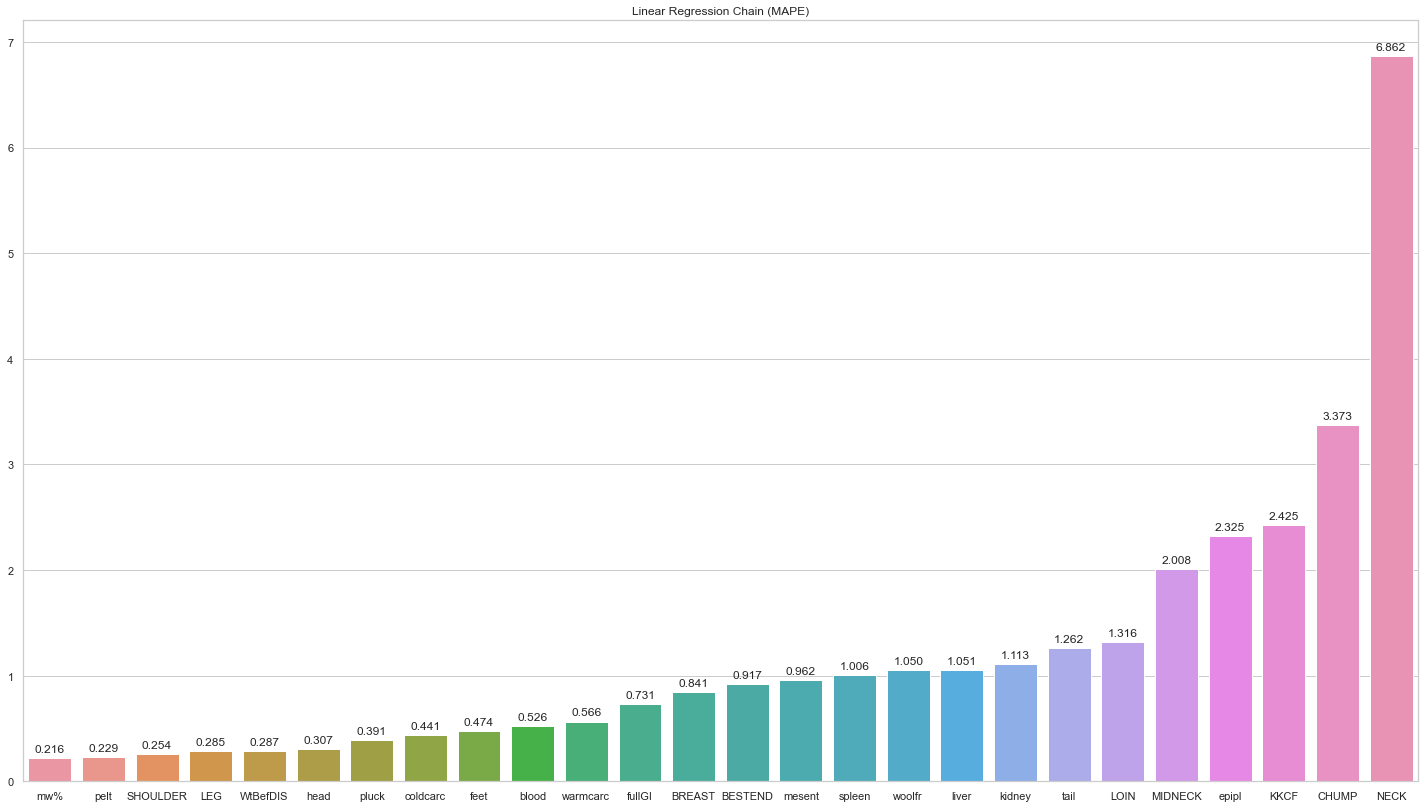

In [4]:
from ChainRegressor import ChainRegressor

# Setup the "chain links"
chain_links_1 = [
    (LinearRegression(), ['WtBefDIS', 'coldcarc', 'warmcarc']),
    (LinearRegression(), ['mesent', 'SHOULDER', 'NECK', 'MIDNECK', 'CHUMP', 'LEG']),
    (LinearRegression(), ['head', 'tail', 'LOIN', 'blood', 'feet', 'pelt', 'spleen', 'pluck', 'kidney', 'BREAST', 'KKCF']),
    (LinearRegression(), ['BESTEND', 'fullGI']),
    (LinearRegression(), ['liver', 'woolfr', 'mw%']),
    (LinearRegression(), ['epipl']),
]

chain_reg = ChainRegressor(chain_links_1)
clinks = chain_reg.fit(X_train, y_train)

# preds = chain_reg.predict(X_test)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print('MAPE:', scores['ua_score_mape'])
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (MAPE)')

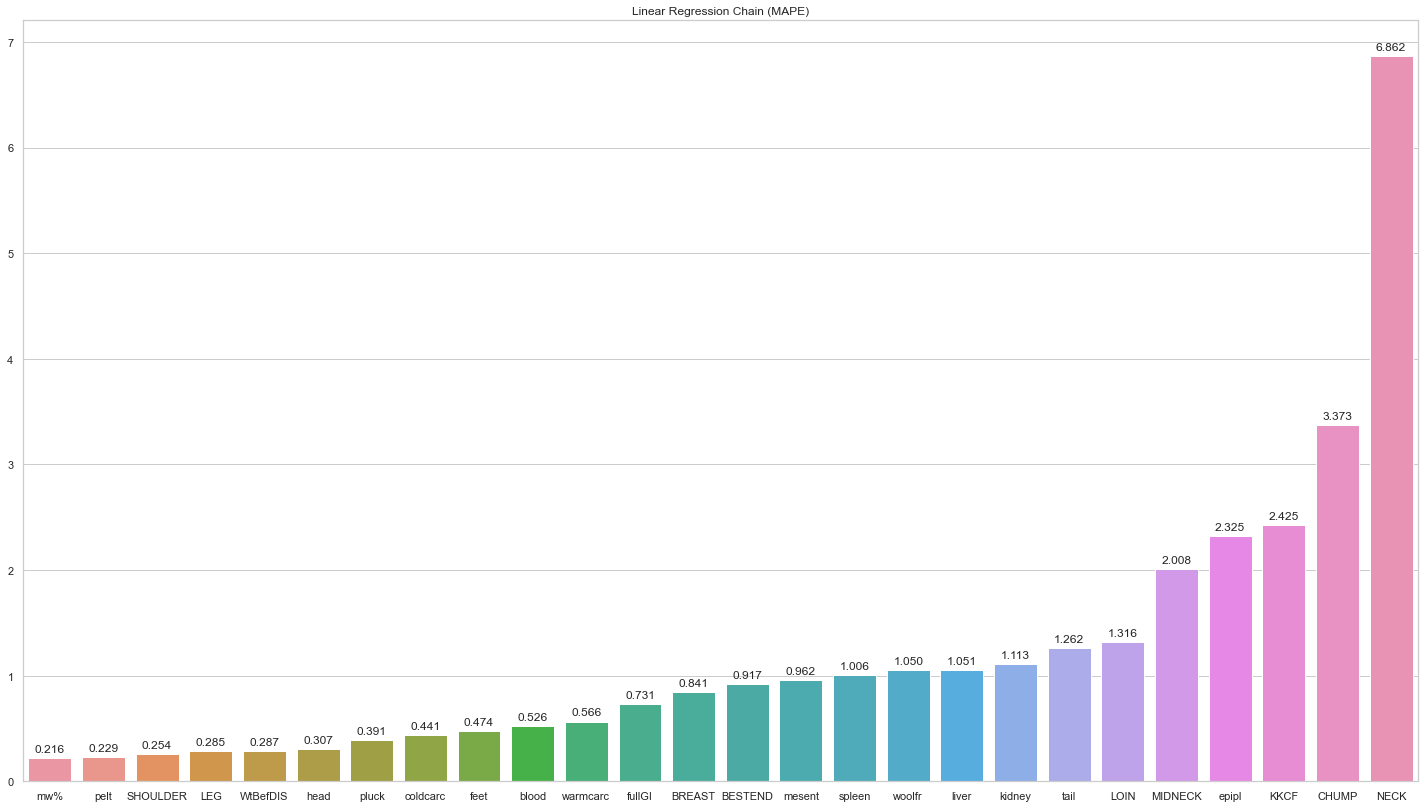

In [5]:
mod = RegressorChain(LinearRegression(), order='random')
mod.fit(X_train, y_train)
scores = mo_reg_scorer(mod, X_test, y_test)
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (MAPE)')

Παρατηρούμε πως μέχρι στιμής η χρήση του chain regressor δεν έφερε καμία απολύτως αλλαγή στην επίδοση του Linear Regression
μοντέλου. Πιό συγκεκριμένα, τα σφάλματα (MAPE) είναι ίδια είτε χρησιμοποιήσουμε random σειρά στο chain είτε επιλέκουμε
μια σειρά βασισμένη στα feature importances.

MAPE: 1.3409285110506015


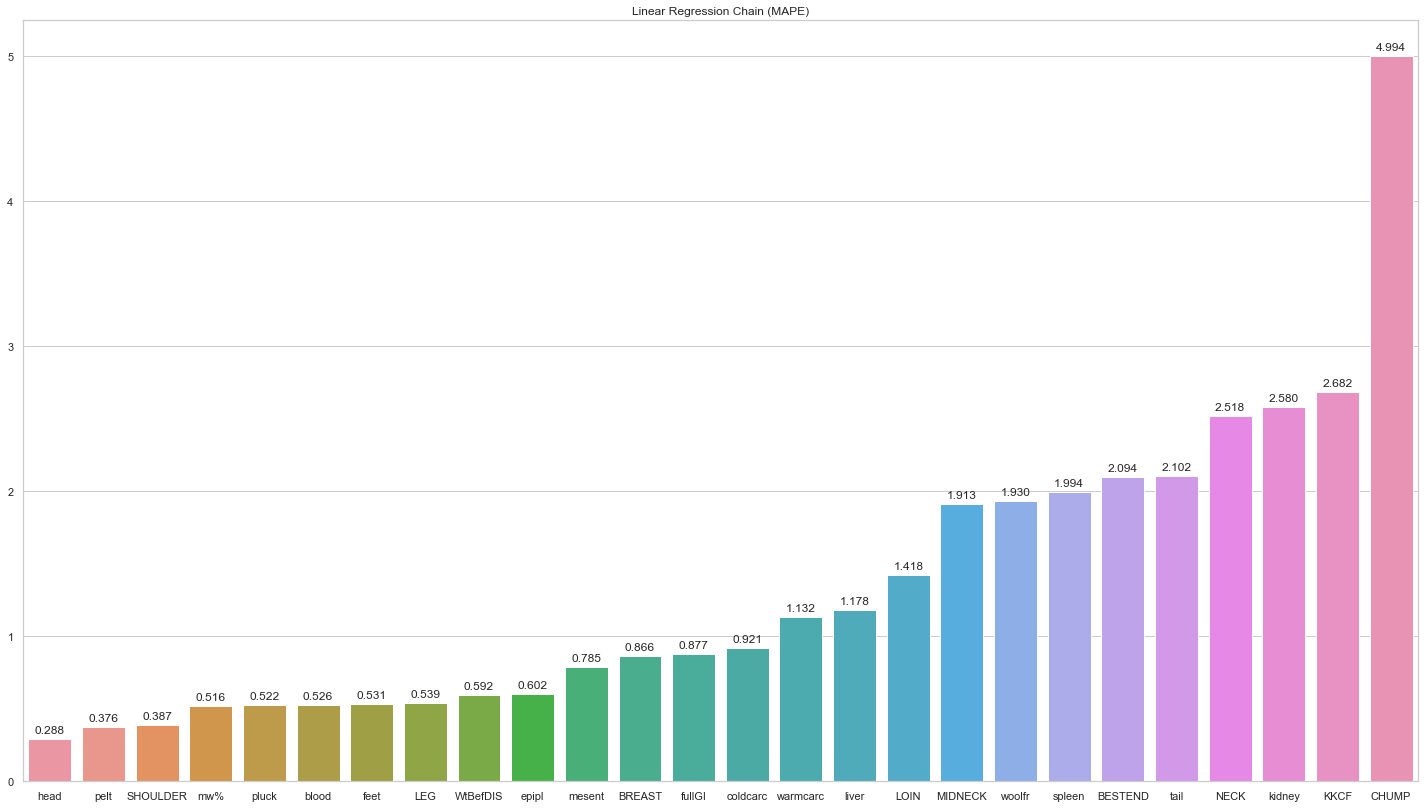

In [7]:
# Setup the "chain links"
chain_links_2 = [
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['WtBefDIS', 'coldcarc', 'warmcarc']),
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['mesent', 'SHOULDER', 'NECK', 'MIDNECK', 'CHUMP', 'LEG']),
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['head', 'tail', 'LOIN', 'blood', 'feet', 'pelt', 'spleen', 'pluck', 'kidney', 'BREAST', 'KKCF']),
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['BESTEND', 'fullGI']),
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['liver', 'woolfr', 'mw%']),
    (MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)), ['epipl']),
]

chain_reg = ChainRegressor(chain_links_2)
clinks = chain_reg.fit(X_train, y_train)

# preds = chain_reg.predict(X_test)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print('MAPE:', scores['ua_score_mape'])
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (MAPE)')

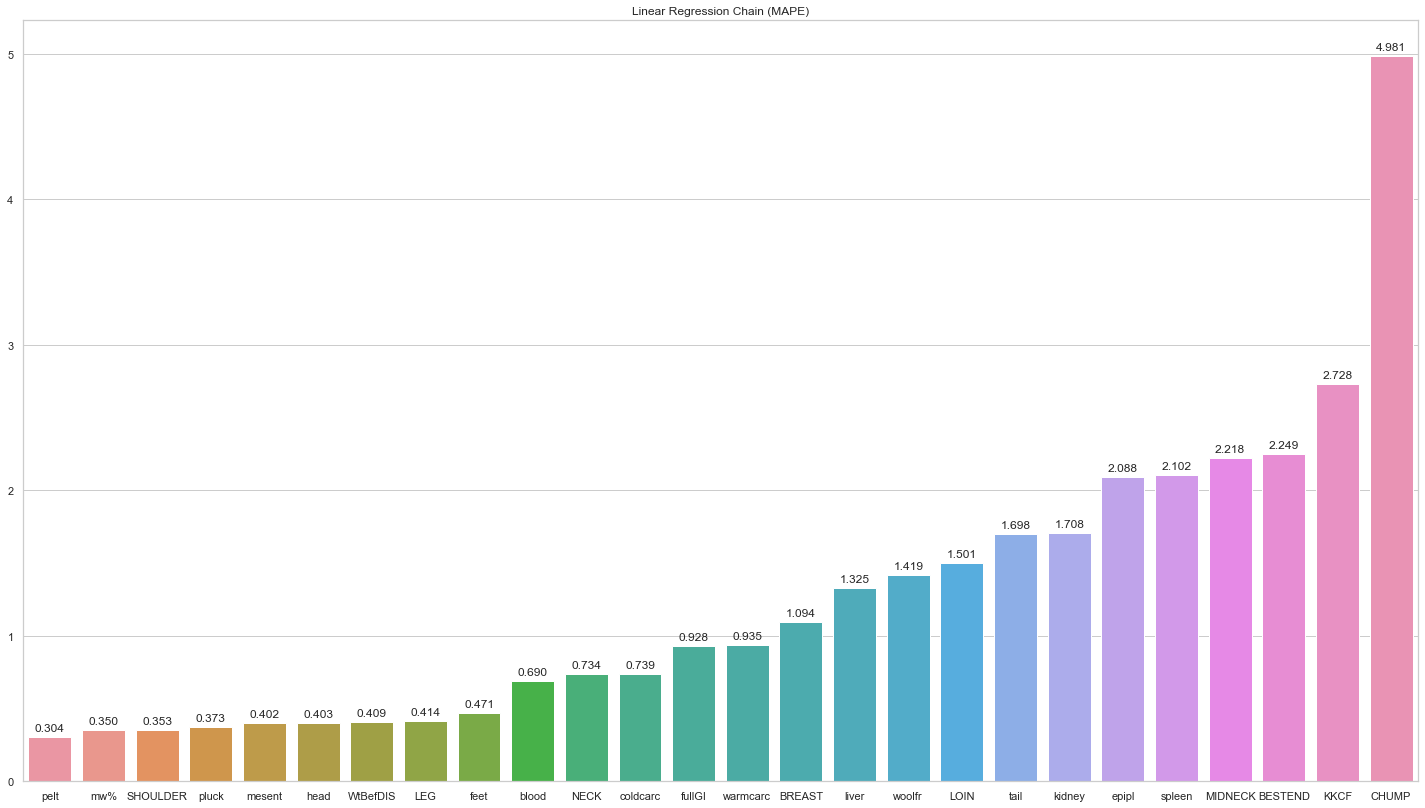

In [9]:
mod = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1), order='random')
mod.fit(X_train, y_train)
scores = mo_reg_scorer(mod, X_test, y_test)
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (MAPE)')

Παρατηρούμε ότι με τη χρήση αποκλειστικά XGBoost ο chain regressor με σειρά πρόβλεψης βασισμένη στα feature importances
έχει ώς αποτέλεσμα μια μικρή μείωση του σφάλματος. Επίσης με τη χρήση chain regressor με τυχαία σειρά παρατηρούνται
αλλαγές στα σφάλματα (MAPE) σε αντίθεση με τη χρήση αποκλειστικά του Linear regression όπως είδαμε παραπάνω.